# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [30]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters'), dtype=object) # récupération des données sur les lettres
Y = np.array(data.get('labels'), dtype=object)  # récupération des étiquettes associées 

Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [31]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [32]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.gcf()
    plt.plot(coord[:,0],coord[:,1])
    # plt.savefig("exlettre.png")
    # plt.show()

Etiquette : "a"


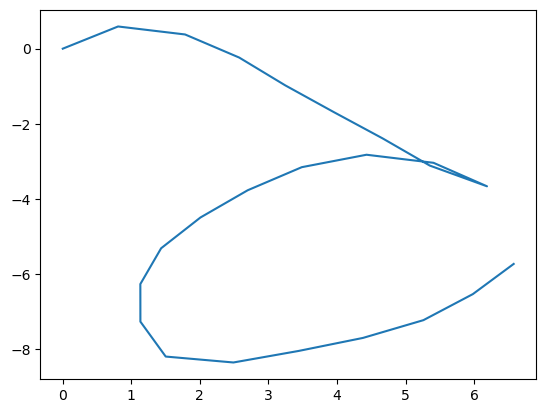

In [33]:
# il s'agit d'un 'a'
tracerLettre(X[0])
print(f"Etiquette : \"{Y[0]}\"") # vérification de l'étiquette

## A. Apprentissage d'un modèle CM (max de vraisemblance)
### A1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats` (18° si on choisit 20 états)
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`
    - si n_etats = 20 alors [0, 18[ => 0, [18, 36[ => 1, etc...

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [69]:
def discretise(x, d):
    intervalle = 360/d
    return np.array([np.floor(lettre / intervalle) for lettre in x], dtype=object)

In [70]:
discretise(X, 3)[0]

array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.])

**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

### A2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [36]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

In [37]:
groupByLabel(Y)[:6]

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype=int64),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], dtype=int64),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype=int64),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], dtype=int64),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=int64)]

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe. Il y a donc 11 exemples de 'a'.

### A3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)
```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()
```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

$\Pi = [\pi_i = P(x_1 = q_i)]$ : état initial de notre séquence (probabilités initiales). <br>
$A = [a_{ij} = P(x_{t+1} = q_j | x_t = q_i)]$ : matrice de transition. 

In [90]:
def learnMarkovModel(Xc, d):
    A  = np.zeros((d,d))
    Pi = np.zeros(d)
    
    for x in Xc:
        x = x.astype(int) # pour éviter d'encombrer nos indexations avec des int(x)...
        
        Pi[x[0]] += 1
        
        for i in range(len(x)-1):
            A[x[i], x[i+1]] += 1    
            
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A

In [92]:
Xd = discretise(X, 3) 
index = groupByLabel(Y)
models = [learnMarkovModel(Xd[index[cl]], 3) for cl in range(len(np.unique(Y)))]

print("------------ Premier modèle (a) ------------")
print(f"Pi =\n{models[0][0]}")
print(f"A =\n{models[0][1]}")
print("----------- Deuxième modèle (b) ------------")
print(f"Pi =\n{models[1][0]}")
print(f"A =\n{models[1][1]}")
print("----------- Troisième modèle (c) -----------")
print(f"Pi =\n{models[2][0]}")
print(f"A =\n{models[2][1]}")

------------ Premier modèle (a) ------------
Pi =
[0.36363636 0.         0.63636364]
A =
[[0.84444444 0.06666667 0.08888889]
 [0.         0.83333333 0.16666667]
 [0.11382114 0.06504065 0.82113821]]
----------- Deuxième modèle (b) ------------
Pi =
[0. 0. 1.]
A =
[[0.81355932 0.         0.18644068]
 [0.         1.         0.        ]
 [0.07857143 0.07857143 0.84285714]]
----------- Troisième modèle (c) -----------
Pi =
[0.27272727 0.72727273 0.        ]
A =
[[0.94736842 0.05263158 0.        ]
 [0.         0.75471698 0.24528302]
 [0.13414634 0.02439024 0.84146341]]


**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

Certains de nos modèles ne sont pas ergodiques !

### A4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [115]:
def storeModels(x, y, d):    # d = paramètre de discrétisation
    Xd = discretise(x, d)    # application de la discrétisation
    index = groupByLabel(y)  # groupement des signaux par classe
    models = [learnMarkovModel(Xd[index[cl]], d) # parcours de toutes les classes et optimisation des modèles
              for cl in range(len(np.unique(y)))] 
    return Xd, models

### A5. Distribution stationnaire

La distribution stationnaire $\mu$, pour un système ergodique, correspond à:

- la distribution des états observés dans l'ensemble des données
- la distribution obtenu après un grand nombre de passage dans $A$ à partir de n'importe quelle distribution ou état d'origine (une matrice de transition ergodique va nous permettre de converger)
- la solution de l'équation de stabilité: $\mu = \mu A$

Dans le cas de la lettre 'a' et d'une discrétisation en 3 états, calculer la distribution stationnaire par les deux première méthode et vérifier que vous obtenez des résultats similaires.

**Note 1:** pour la marche aléatoire, vous construirez une boucle sur 100 itérations (borne sup) et vous sortirez dès que la somme des écarts (en absolu) entre $\mu_t$ et $\mu_{t+1}$ est inférieure à $10^{-3}$. Vous vérifierez ensuite que le système converge quelque soit l'état de départ (3 appels à la fonction) ou avec une initialisation aléatoire.

**Note 2:** les deux approches, bien que reposant sur les mêmes données, vont donner des solutions différentes. En effet, il n'y a que peu d'observations et le premier calcul repose sur les états alors que le second repose sur les transitions. 
Afin de vérifier l'exactitude de votre code, vous pourrez revenir sur cette question en fin de sujet avec le protocole suivant:
1. utiliser la matrice de transition de 'a' pour générer une séquence de longeur 100000
1. faire les statistiques des états (à l'aide d'un ```Counter``` par exemple)
1. vérifier la convergence sur de longues séquences

In [117]:
def calculDistribution(models, d):
    mu = np.zeros(d)
    for d in range(d):
        for x in models:
            mu[d] += np.sum(np.where(x == d, 1, 0))
    return mu / mu.sum()

def marcheAleatoire(models, cl, bornesup=100, e=1e-3):
    mu, A = models[cl][0], models[cl][1]
    for i in range(bornesup):
        mu_t = np.dot(mu, A)
        if np.sum(np.abs(mu_t - mu)) < e:
            return mu_t
        mu = mu_t
    return mu

In [118]:
Xd, models = storeModels(X, Y, 3)
print(f"Distribution des états observés dans l'ensemble des données : µ = {calculDistribution(model, 3)}")
print(f"Marche aléatoire : µ = {marcheAleatoire(models, 0)}")

Distribution des états observés dans l'ensemble des données : µ = [0.22857143 0.26938776 0.50204082]
Marche aléatoire : µ = [0.30477844 0.28202157 0.41319999]


**Note :** Le premier modèle n'est pas ergodique : il est impossible de revenir au premier état lorsque nous sommes dans le $2^e$.

##  B. Test (affectation dans les classes sur critère MV)
### B1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [119]:
np.seterr(divide = 'ignore') # pour désactiver les `RuntimeWarning` lorsque p = log(0)

def probaSequence(s, Pi, A):
    s = s.astype(int) # pour éviter d'encombrer nos indexations
    proba = Pi[s[0]]
    for i in range(len(s)-1):
        proba *= A[s[i], s[i+1]]
    return np.log(proba)

In [120]:
d = 3
Xd, models = storeModels(X, Y, d) # discrétisation sur 3 états
proba = np.array( [ probaSequence(Xd[0], models[cl][0], models[cl][1])
                   for cl in range( len( np.unique(Y) ) ) ] )
print(proba)

[-13.491086           -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
 -12.48285678]


**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?

Le signal a plus de chance d'être classé comme 'z' au lieu de 'a', bien que les probas soient proches.
- D'où viennent tous les `-inf` ? 

$\lim\limits_{x \rightarrow 0} \log(x) = -\infty \iff P(s|\lambda)=0$ : nos probabilités sont nulles pour ces étiquettes (par exemple le premier signal a 0 % de chance d'être 'b' ou 'c', ...).

### B2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [121]:
proba = np.array([ [ probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range( len(Xd) ) ]
                  for cl in range( len( np.unique(Y) ) ) ])

### B3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [122]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
print(f"Indice de performance (% de bonne classification), d = {d} :\n", np.where(pred != Ynum, 0.,1.).mean())

Indice de performance (% de bonne classification), d = 3 :
 0.6902985074626866


In [123]:
d = 20
Xd, models = storeModels(X, Y, d) # discrétisation sur 20 états
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
print(f"Indice de performance (% de bonne classification), d = {d} :\n", np.where(pred != Ynum, 0.,1.).mean())

Indice de performance (% de bonne classification), d = 20 :
 0.914179104477612


**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

## C. Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [124]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [125]:
itrain

[array([ 5, 10,  0,  6,  1,  2,  7,  8], dtype=int64),
 array([20, 16, 19, 11, 15, 12, 18, 17], dtype=int64),
 array([26, 23, 31, 27, 29, 32, 24, 28], dtype=int64),
 array([38, 40, 39, 35, 41, 36, 37, 42], dtype=int64),
 array([45, 51, 54, 44, 52, 53, 48, 49], dtype=int64),
 array([62, 56, 60, 65, 57, 55, 58, 63], dtype=int64),
 array([72, 75, 67, 74, 76, 70, 68, 71], dtype=int64),
 array([86, 80, 87, 78, 85, 81, 79, 77], dtype=int64),
 array([91, 96, 95, 89, 93, 92, 97, 94], dtype=int64),
 array([105,  98, 106, 100, 107,  99, 101, 103], dtype=int64),
 array([114, 109, 112, 110, 115, 117, 116, 108], dtype=int64),
 array([119, 126, 125, 127, 118, 122, 124, 123], dtype=int64),
 array([134, 132, 131, 129, 136, 130, 133, 137], dtype=int64),
 array([139, 145, 140, 147, 144, 141, 143, 146], dtype=int64),
 array([153, 155, 154, 151, 156, 148, 150, 152], dtype=int64),
 array([159, 163, 158, 167, 161, 166, 160, 162], dtype=int64),
 array([176, 173, 174, 177, 175, 169, 171, 172], dtype=int64),
 

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [126]:
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

In [136]:
# cela peut également se faire avec :
# ia = np.concatenate(itrain)
# it = np.concatenate(itest) 

In [152]:
itrain

[array([ 5, 10,  0,  6,  1,  2,  7,  8], dtype=int64),
 array([20, 16, 19, 11, 15, 12, 18, 17], dtype=int64),
 array([26, 23, 31, 27, 29, 32, 24, 28], dtype=int64),
 array([38, 40, 39, 35, 41, 36, 37, 42], dtype=int64),
 array([45, 51, 54, 44, 52, 53, 48, 49], dtype=int64),
 array([62, 56, 60, 65, 57, 55, 58, 63], dtype=int64),
 array([72, 75, 67, 74, 76, 70, 68, 71], dtype=int64),
 array([86, 80, 87, 78, 85, 81, 79, 77], dtype=int64),
 array([91, 96, 95, 89, 93, 92, 97, 94], dtype=int64),
 array([105,  98, 106, 100, 107,  99, 101, 103], dtype=int64),
 array([114, 109, 112, 110, 115, 117, 116, 108], dtype=int64),
 array([119, 126, 125, 127, 118, 122, 124, 123], dtype=int64),
 array([134, 132, 131, 129, 136, 130, 133, 137], dtype=int64),
 array([139, 145, 140, 147, 144, 141, 143, 146], dtype=int64),
 array([153, 155, 154, 151, 156, 148, 150, 152], dtype=int64),
 array([159, 163, 158, 167, 161, 166, 160, 162], dtype=int64),
 array([176, 173, 174, 177, 175, 169, 171, 172], dtype=int64),
 

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

### C1. Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [169]:
def storeModelsApprentissage(x, y, d): 
    Xd = discretise(x, d)         # application de la discrétisation
    models = [learnMarkovModel(Xd[y[cl]], d) for cl in range(len(y))] 
    return Xd, models

In [170]:
d = 3
Xd, models = storeModelsApprentissage(X, itrain, d) # discrétisation sur 3 états

# calcul des probas sur les données d'apprentissage
proba_train = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in ia]
                        for cl in range(len(itrain))])

# calcul des probas sur les données de test
proba_test = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in it]
                       for cl in range(len(itest))])

# calcul d'une version numérique des Y d'apprentissage :
inum_train = Ynum[ia]
for num, char in enumerate((ia)):
    inum_train[itrain == char] = num

# calcul d'une version numérique des Y d'évaluation :
inum_test = Ynum[it]
for num, char in enumerate((it)):
    inum_test[itest == char] = num

# Calcul de la classe la plus probable :
pred_train = proba_train.argmax(0) # max colonne par colonne
pred_test = proba_test.argmax(0) # max colonne par colonne

# Calcul du pourcentage de bonne classification pour les deux jeux de données  :
print(f"Indice de performance, données d'apprentissage, d = {d} :\n",
      np.where(pred_train != inum_train, 0.,1.).mean())
print(f"Indice de performance, données de test, d = {d} :\n",
      np.where(pred_test != inum_test, 0.,1.).mean())

Indice de performance, données d'apprentissage, d = 3 :
 0.6875
Indice de performance, données de test, d = 3 :
 0.6166666666666667


In [171]:
d = 20
Xd, models = storeModelsApprentissage(X, itrain, d) # discrétisation sur 20 états
 
proba_train = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in ia]
                        for cl in range(len(itrain))])
proba_test = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in it]
                       for cl in range(len(itest))])

# calcul d'une version numérique des Y d'apprentissage :
inum_train = Ynum[ia]
for num, char in enumerate((ia)):
    inum_train[itrain == char] = num

# calcul d'une version numérique des Y d'évaluation :
inum_test = Ynum[it]
for num, char in enumerate((it)):
    inum_test[itest == char] = num

# Calcul de la classe la plus probable :
pred_train = proba_train.argmax(0) # max colonne par colonne
pred_test = proba_test.argmax(0) # max colonne par colonne

# Calcul du pourcentage de bonne classification pour les deux jeux de données  :
print(f"Indice de performance, données d'apprentissage, d = {d} :\n",
      np.where(pred_train != inum_train, 0.,1.).mean())
print(f"Indice de performance, données de test, d = {d} :\n",
      np.where(pred_test != inum_test, 0.,1.).mean())

Indice de performance, données d'apprentissage, d = 20 :
 0.9086538461538461
Indice de performance, données de test, d = 20 :
 0.3


In [174]:
def plotIndicePerformance(x, y, d, pc):
    # jeux de données
    itrain, itest = separeTrainTest(y, pc)
    ia = []
    for i in itrain:
        ia += i.tolist()    
    it = []
    for i in itest:
        it += i.tolist()
    
    # init
    perf_train, perf_test = [], []
    etats = range(1, d+1)
    
    # init figure
    fig = plt.figure(figsize=(10,6))
    plt.xticks(etats)
    plt.ylim(0, 1)
    plt.xlabel("Nombre d'états")
    plt.ylabel("Indice de performance")
    
    # calculs pour chacun de nos états
    for d in etats:
        Xd, models = storeModelsApprentissage(x, itrain, d) # discrétisation sur d états
        
        # calcul des probas
        proba_train = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in ia]
                                for cl in range(len(itrain))])
        proba_test = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in it]
                               for cl in range(len(itest))])
        
        # calcul d'une version numérique des Y d'apprentissage :
        inum_train = Ynum[ia]
        for num, char in enumerate((ia)):
            inum_train[itrain == char] = num

        # calcul d'une version numérique des Y d'évaluation :
        inum_test = Ynum[it]
        for num, char in enumerate((it)):
            inum_test[itest == char] = num
            
        pred_train = proba_train.argmax(0) # max colonne par colonne
        pred_test = proba_test.argmax(0) # max colonne par colonne
        
        perf_train.append(np.where(pred_train != inum_train, 0., 1.).mean()) # ind de performance données de train
        perf_test.append(np.where(pred_test != inum_test, 0., 1.).mean()) # ind de performance données de test
    
    plt.plot(etats, perf_train, label="Données d'apprentissage")
    plt.plot(etats, perf_test, label="Données de test")
    plt.legend(loc="upper left")
    plt.title(f"Indices de performance, $p_c={pc}$")
    plt.show()

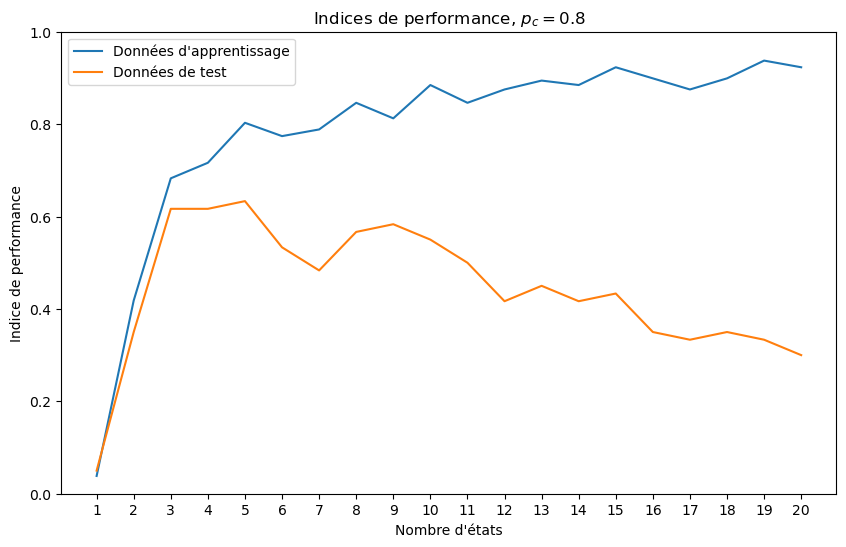

In [175]:
plotIndicePerformance(X, Y, 20, 0.8) 

Beaucoup plus robuste avec peu d'états car problème de sur-apprentissage.

### C2. Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [176]:
def learnMarkovModel(Xc, d):
    A  = np.ones((d,d))
    Pi = np.ones(d)
    
    for x in Xc:
        x = x.astype(int) # pour éviter d'encombrer nos indexations avec des int(x)...
        
        Pi[x[0]] += 1
        
        for i in range(len(x)-1):
            A[x[i], x[i+1]] += 1    
            
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A

In [177]:
# maintenant il nous suffit de reprendre le code d'avant...
d = 20
Xd, models = storeModelsApprentissage(X, itrain, d) # discrétisation sur 20 états
 
proba_train = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in ia]
                        for cl in range(len(itrain))])
proba_test = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in it]
                       for cl in range(len(itest))])

# calcul d'une version numérique des Y d'apprentissage :
inum_train = Ynum[ia]
for num, char in enumerate((ia)):
    inum_train[itrain == char] = num

# calcul d'une version numérique des Y d'évaluation :
inum_test = Ynum[it]
for num, char in enumerate((it)):
    inum_test[itest == char] = num

# Calcul de la classe la plus probable :
pred_train = proba_train.argmax(0) # max colonne par colonne
pred_test = proba_test.argmax(0) # max colonne par colonne

# Calcul du pourcentage de bonne classification pour les deux jeux de données  :
print(f"Indice de performance, données d'apprentissage, d = {d} :\n",
      np.where(pred_train != inum_train, 0.,1.).mean())
print(f"Indice de performance, données de test, d = {d} :\n",
      np.where(pred_test != inum_test, 0.,1.).mean())
# on a presque multiplié par 6 notre indice de performance !

Indice de performance, données d'apprentissage, d = 20 :
 0.8269230769230769
Indice de performance, données de test, d = 20 :
 0.6333333333333333


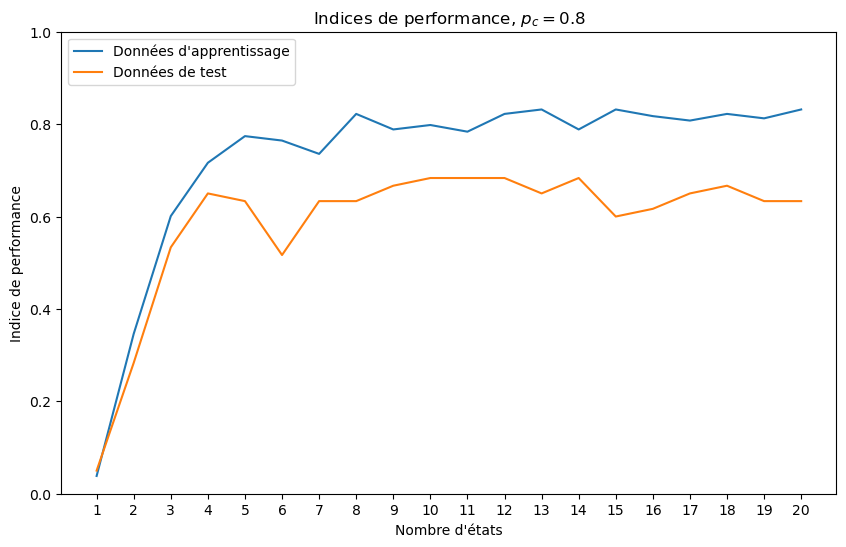

In [182]:
plotIndicePerformance(X, Y, 20, 0.8)

Beaucoup plus robuste face au sur-apprentissage ! :)

## D. Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant $N_c$ le nombre de classes, la matrice de confusion est une matrice ($N_c \times N_c$) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [190]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

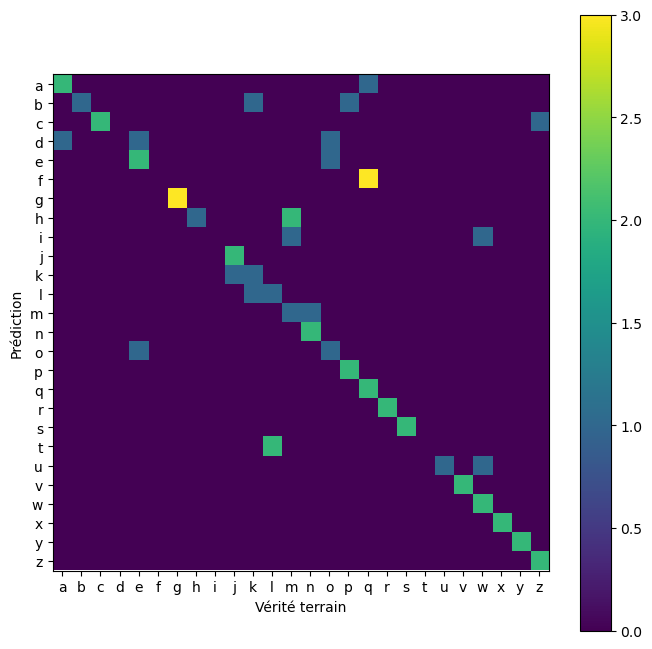

In [191]:
for counter, value in enumerate(pred_test):
    conf[ int( inum_test[counter] ), int(value) ] += 1
    
plt.figure(figsize=(8,8))
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
# plt.savefig("mat_conf_lettres.png")
plt.show()

In [194]:
def matrice_confusion(Y, d, pc):
    """ version générique et réutilisable """
    Nc = len(np.unique(Y))    # nombre de classes
    conf = np.zeros((Nc, Nc)) # matrice de confusion
    
    # séparation des données
    itrain, itest = separeTrainTest(Y, pc)    
    it = []
    for i in itest:
        it += i.tolist()
    
    # récupération des modèles
    Xd, models = storeModelsApprentissage(X, itrain, d)
    
    proba_test = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in it]
                          for cl in range(len(itest))])
    
    # calcul d'une version numérique des Y
    Ynum = np.zeros(Y.shape)
    for num, char in enumerate(np.unique(Y)):
        Ynum[Y == char] = num
    
    # calcul d'une version numérique des Y d'évaluation :
    inum_test = Ynum[it]
    for num, char in enumerate((it)):
        inum_test[itest == char] = num

    # prédictions
    pred_test = proba_test.argmax(0) # max colonne par colonne
    
    # calcul de la matrice de prédiction
    for i in range(Nc):
        etiquettes, counts = np.unique(np.array(pred_test)[inum_test==i], return_counts=True)
        conf[i, etiquettes] = counts
    return conf

- Tracé de la matrice : 

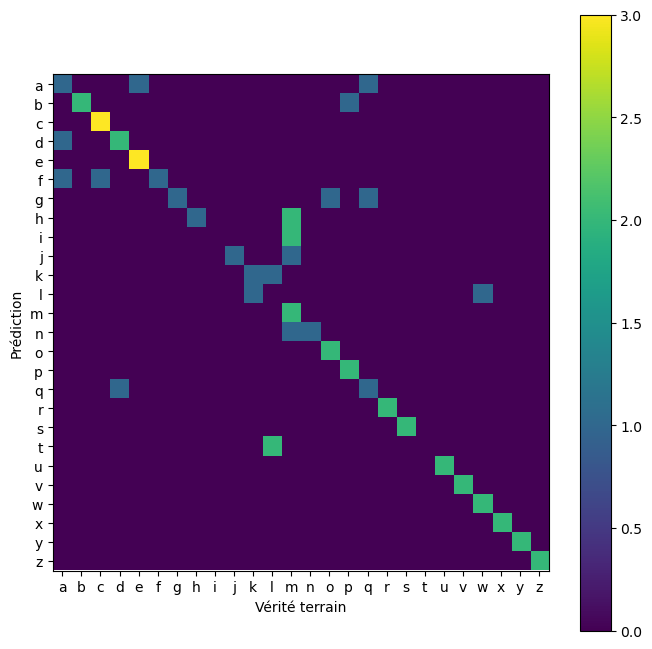

In [195]:
conf = matrice_confusion(Y, 20, 0.8) # 20 états, 20 % de données de test

plt.figure(figsize=(8,8))
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
# plt.savefig("mat_conf_lettres.png")
plt.show()

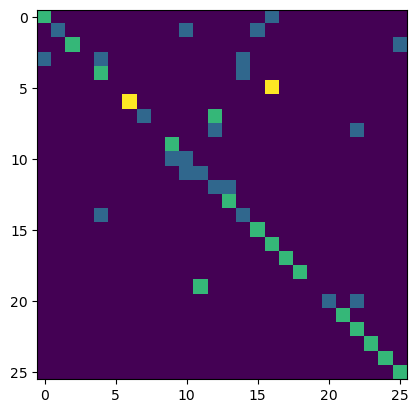

In [200]:
# vérification avec scipy
from sklearn.metrics import confusion_matrix
plt.imshow(confusion_matrix(inum_test, pred_test), interpolation = 'nearest')
plt.show()

## E. Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### E1. Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### E2. Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [63]:
# Votre code
def generate(Pi, A, N):
    A_sc = A.cumsum(axis=1)
    seq = [ np.where(Pi.cumsum() > np.random.rand())[0][0] ] # s_0
    for i in range(1, N):
        seq.append( np.where(A_sc[seq[i-1]] > np.random.rand())[0][0] )
    return seq

### E3. Affichage du résultat

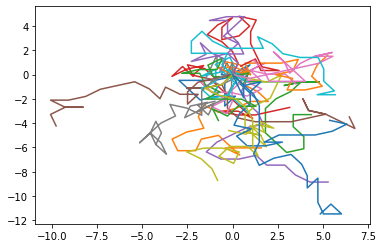

In [83]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()

def animate(i):
    d = 20
    itrain, itest = separeTrainTest(Y, 0.7)
    Xd, models = storeModelsApprentissage(d, itrain)
    newa = generate(models[0][0], models[0][1], 20)         # generation d'une séquence d'états
    intervalle = 360. / d                                   # pour passer des états => valeur d'angles
    newa_continu = np.array([i * intervalle for i in newa]) # conv int => double
    tracerLettre(newa_continu)
    
anim = animation.FuncAnimation(fig, animate, frames=20)
HTML(anim.to_html5_video())

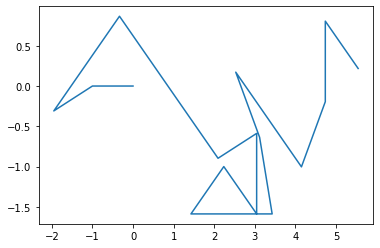

In [147]:
d = 20
Xd, models = storeModelsApprentissage(d, itrain)
newb = generate(models[0][0], models[0][1], 20)         # generation d'une séquence d'états
intervalle = 360. / d                                   # pour passer des états => valeur d'angles
newb_continu = np.array(newb) * intervalle              # conv int => double
tracerLettre(newb_continu)

In [162]:
Xd[0]

array([ 2., 19., 17., 17., 17., 17., 17., 18.,  7.,  9., 11., 12., 12.,
       13., 14., 15., 16., 19.,  0.,  1.,  1.,  2.,  2.])

In [163]:
t = [generate(models[i][0], models[i][1], 100000) for i in range(26)]

[0,
 16,
 15,
 4,
 11,
 18,
 6,
 1,
 9,
 17,
 19,
 18,
 17,
 15,
 15,
 3,
 6,
 0,
 0,
 18,
 11,
 13,
 15,
 4,
 10,
 18,
 18,
 12,
 14,
 3,
 5,
 3,
 12,
 19,
 7,
 8,
 2,
 4,
 16,
 1,
 3,
 14,
 15,
 15,
 15,
 13,
 5,
 11,
 14,
 16,
 19,
 4,
 0,
 1,
 1,
 11,
 12,
 12,
 16,
 8,
 7,
 2,
 6,
 15,
 12,
 0,
 18,
 13,
 14,
 5,
 11,
 10,
 18,
 0,
 12,
 12,
 2,
 0,
 15,
 6,
 1,
 9,
 6,
 14,
 16,
 16,
 9,
 10,
 17,
 11,
 12,
 7,
 1,
 1,
 10,
 4,
 3,
 15,
 16,
 19,
 0,
 2,
 9,
 4,
 19,
 0,
 1,
 1,
 19,
 12,
 17,
 11,
 12,
 13,
 14,
 14,
 18,
 17,
 13,
 1,
 2,
 19,
 18,
 7,
 8,
 13,
 15,
 14,
 4,
 0,
 1,
 2,
 3,
 7,
 6,
 4,
 3,
 15,
 6,
 9,
 11,
 5,
 19,
 12,
 12,
 7,
 14,
 5,
 3,
 15,
 10,
 10,
 11,
 13,
 12,
 13,
 16,
 19,
 2,
 18,
 9,
 5,
 14,
 5,
 13,
 6,
 13,
 15,
 12,
 15,
 11,
 9,
 10,
 9,
 10,
 11,
 10,
 14,
 11,
 7,
 17,
 12,
 10,
 11,
 9,
 10,
 0,
 1,
 14,
 5,
 6,
 8,
 15,
 16,
 18,
 18,
 10,
 9,
 12,
 5,
 19,
 18,
 15,
 19,
 10,
 11,
 10,
 11,
 16,
 11,
 10,
 18,
 7,
 4,
 11,
 5,
 14,
 6,

In [166]:
print(f"Distribution des états observés dans l'ensemble des données : µ = {calculDistribution(t[0], d)}")

Distribution des états observés dans l'ensemble des données : µ = [0.06255 0.05977 0.04388 0.03865 0.03614 0.03603 0.03763 0.03783 0.04154
 0.03888 0.05084 0.06063 0.05712 0.04768 0.04574 0.05925 0.06841 0.06415
 0.05907 0.05421]


In [164]:
print(f"Marche aléatoire : µ = {marcheAleatoire(t, d)}")

Marche aléatoire : µ = [0.05423526 0.04918064 0.04705334 0.05499096 0.05256931 0.04676926
 0.04097236 0.03925217 0.03998079 0.03914327 0.0432521  0.04432903
 0.05011262 0.04743865 0.05706801 0.08707986 0.06154558 0.051652
 0.0467636  0.04661118]
